In [1]:
import torch
import seaborn as sn
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, cohen_kappa_score
from model.classifier import Classifier
import torch
from torch.utils.data import DataLoader
from utils.data_loading import NucleiDataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import captum as c

## Dataset + model preparation

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Classifier(n_channels=3, n_classes=7)
net.load_state_dict(torch.load(
    './outputs/SpringNet-no_overlap-watershed-balanced/checkpoint_epoch28.pth',
    map_location=device))
net.to(device=torch.device('cuda'))

test_set_path = "../segmentation_postprocessing/patch_datasets/watershed_presplit_balanced/test"
test_set = NucleiDataset(test_set_path, mode='test')
test_loader = DataLoader(test_set, shuffle=True, drop_last=False, batch_size=8192, num_workers=0)

## Guided GradCAM

Prepare a batch of data for visualization

In [3]:
guided_gc = c.attr.GuidedGradCam(net, net.large_spring_2)
for batch in test_loader:
    images = batch['image']
    classes = batch['class']

    images = images.to(device=device, dtype=torch.float32)
    classes = classes.to(device=device, dtype=torch.uint8)
    break

Visualize Guided GradCAM for a prespecified image in the batch

C:\Users\Lukas\AppData\Local\Temp\ipykernel_6772\3988194827.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted_class = torch.nn.functional.softmax(net(images[i_idx].unsqueeze(0))).argmax().cpu().numpy()


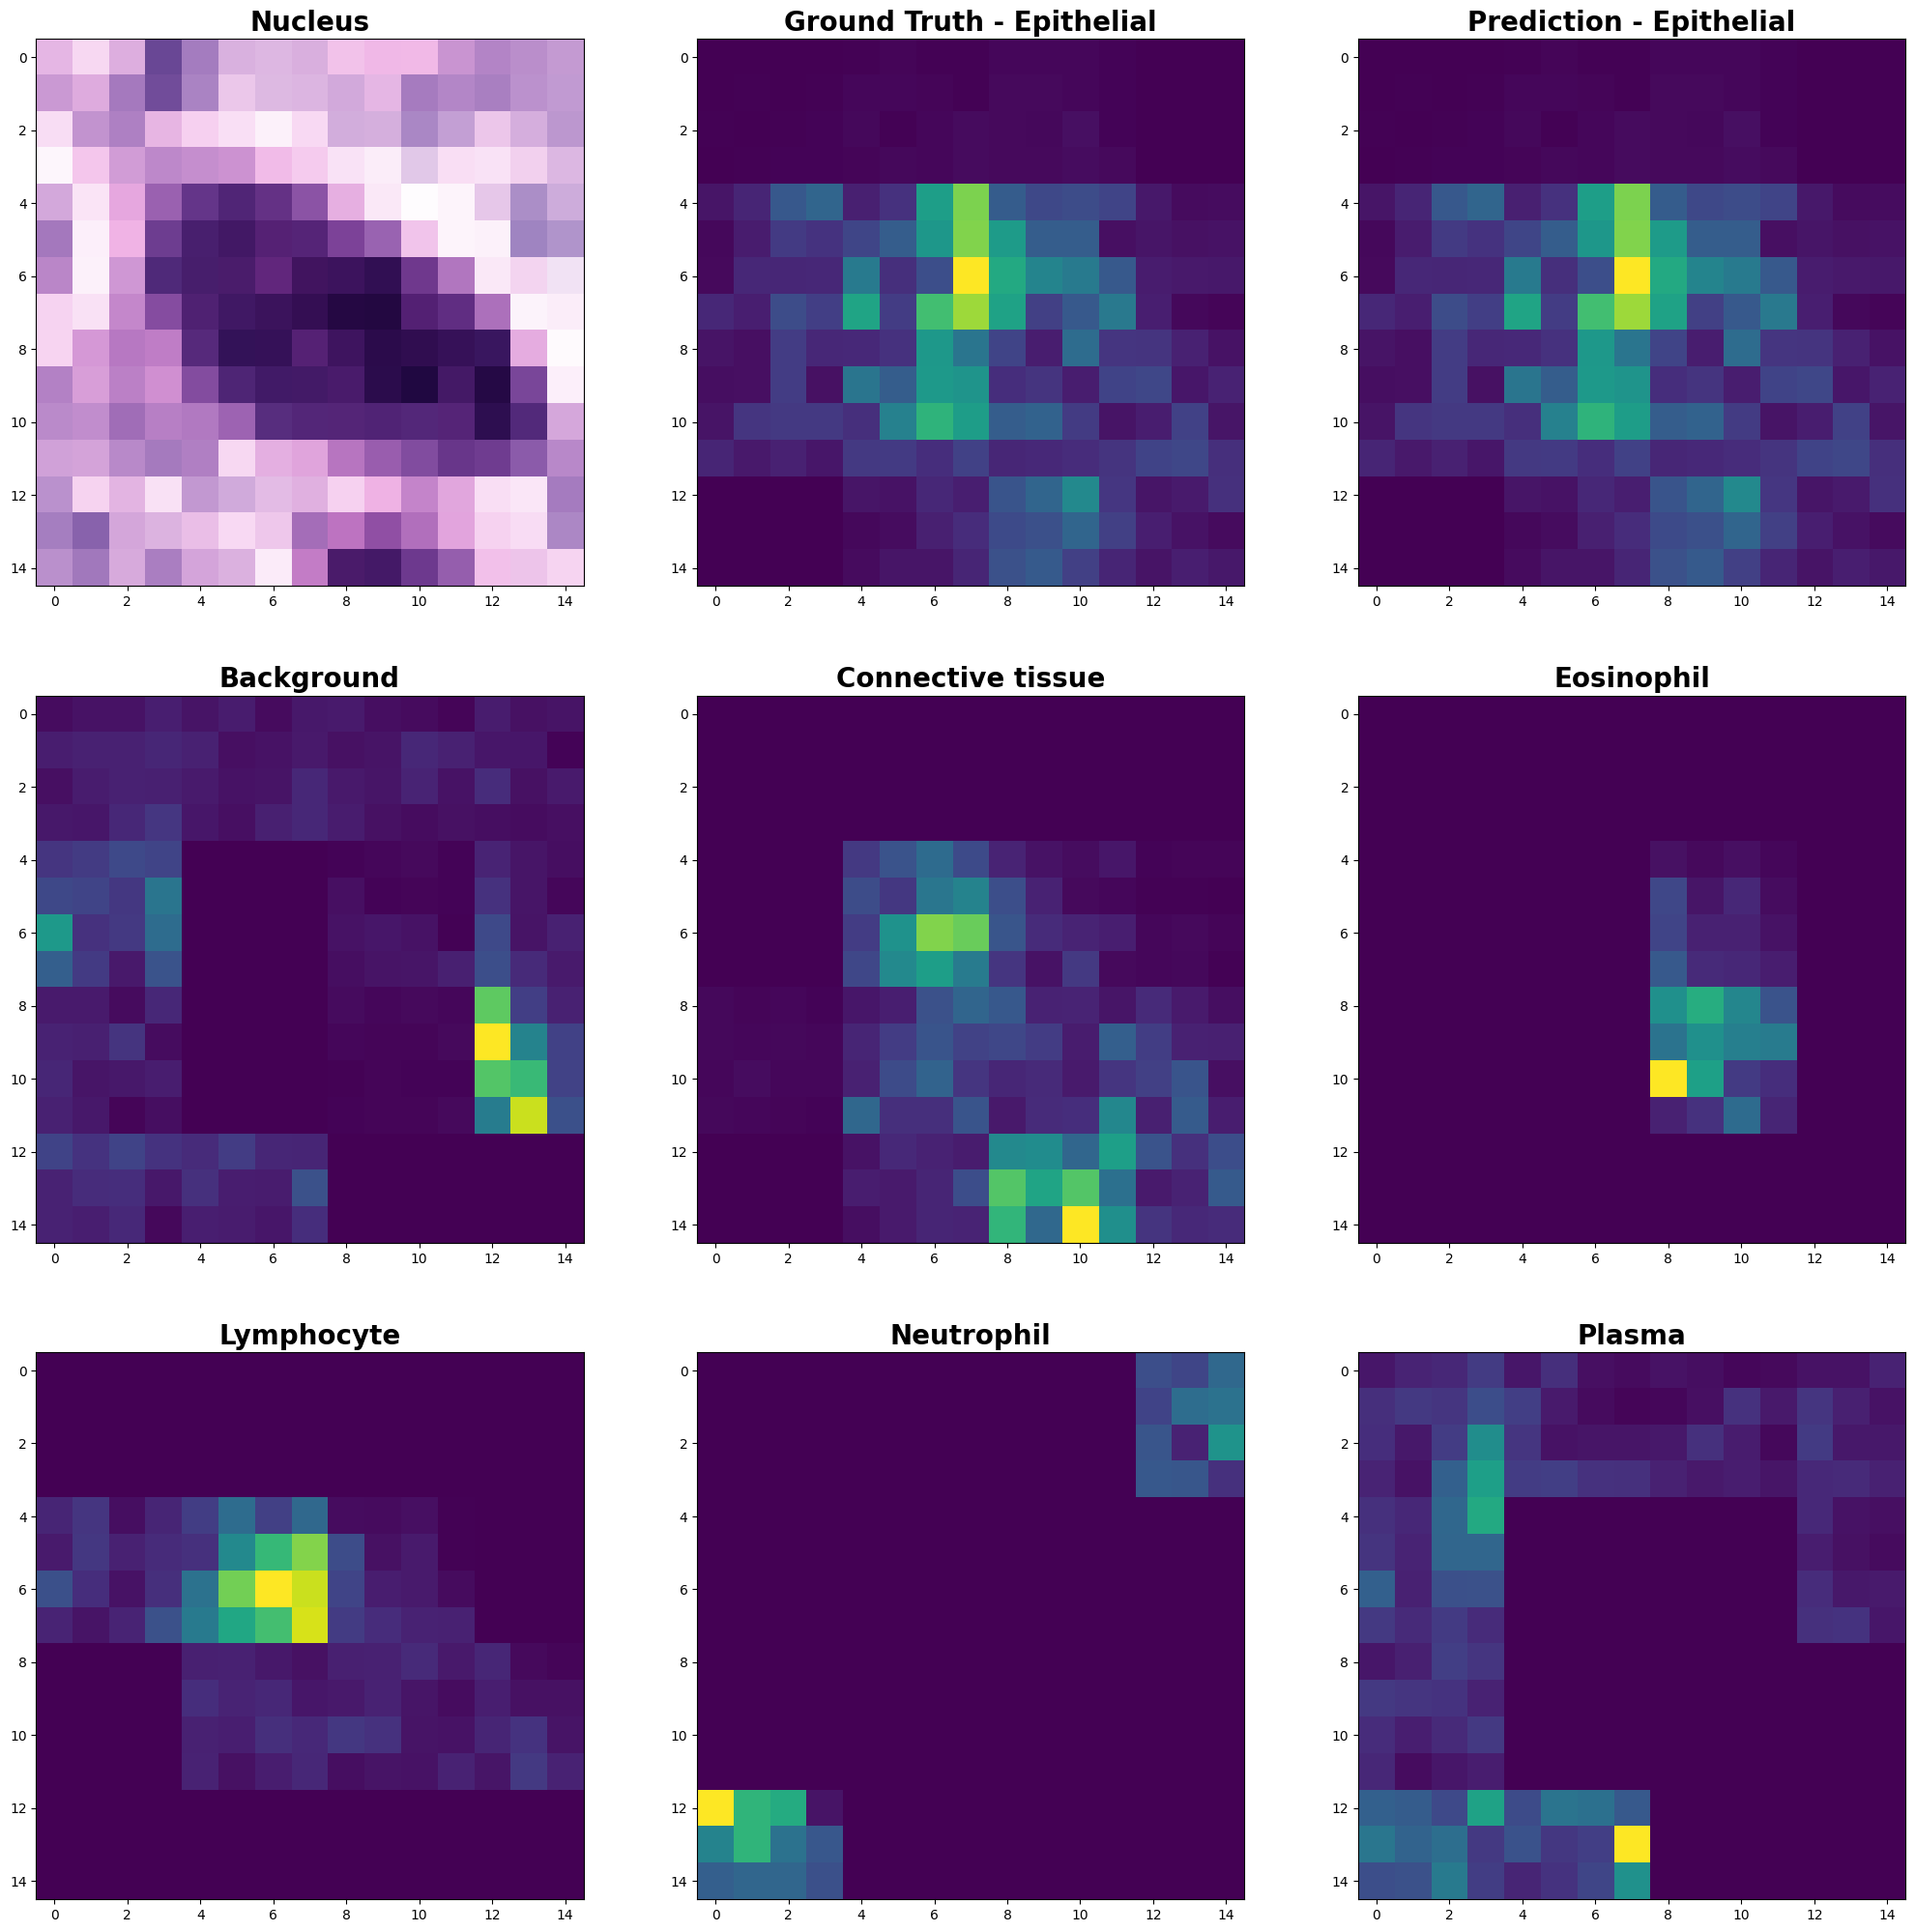

In [303]:
# USE THIS TO ITERATE THROUGH THE BATCH
i_idx = 30

class_mappings = {0: 'Background', 1: 'Connective tissue', 2: 'Eosinophil', 3: 'Epithelial',
                          4: 'Lymphocyte', 5: 'Neutrophil', 6: 'Plasma'}

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(25, 25))
ax[0, 0].imshow(images[i_idx].detach().cpu().numpy().transpose(1, 2, 0).astype(np.uint8))
ax[0, 0].set_title('Nucleus', size=20, fontweight="bold")

lab_idx = int(classes[i_idx].cpu().numpy())

attribution = guided_gc.attribute(images, lab_idx)
a = np.abs(attribution.cpu().detach().numpy()).sum(axis=1)
a = (a - a.min()) / (a.max() - a.min())

summed_attr = a[i_idx]
ax[0, 1].imshow(summed_attr, vmin=0, vmax=np.max(summed_attr))
ax[0, 1].set_title(f'Ground Truth - {class_mappings[lab_idx]}', size=20, fontweight="bold")

predicted_class = torch.nn.functional.softmax(net(images[i_idx].unsqueeze(0))).argmax().cpu().numpy()
predicted_class = int(predicted_class)

if predicted_class != lab_idx:
    attribution = guided_gc.attribute(images, predicted_class)
    a = np.abs(attribution.cpu().detach().numpy()).sum(axis=1)
    a = (a - a.min()) / (a.max() - a.min())

summed_attr = a[i_idx]
ax[0, 2].imshow(summed_attr, vmin=0, vmax=np.max(summed_attr))
ax[0, 2].set_title(f'Prediction - {class_mappings[predicted_class]}', size=20, fontweight="bold")

count = 0

for c_idx in range(7):
    if c_idx == lab_idx or c_idx == predicted_class:
        continue
    attribution = guided_gc.attribute(images, c_idx)
    
    # ax[count, 0].axis('off')

    a = np.abs(attribution.cpu().detach().numpy()).sum(axis=1)
    a = (a - a.min()) / (a.max() - a.min())

    summed_attr = a[i_idx]

    summed_attr = np.abs(attribution[i_idx].detach().cpu().numpy()).sum(axis=0)
    ax[np.floor(count/3).astype(np.int16)+1, count%3].imshow(summed_attr, vmin=0, vmax=np.max(summed_attr))
    ax[np.floor(count/3).astype(np.int16)+1, count%3].set_title(class_mappings[c_idx], size=20, fontweight="bold")
    
    count += 1
    
plt.show()